In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'ADM'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../csv_files/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2001-03-31,5130,-4761,369,93,581,2156,2693,6042,0,...,14155,1707,986,20,3496,3710,7928,117,-66,631
1,2001-06-30,5345,-4983,362,56,676,2416,2632,6150,0,...,14340,1795,876,382,3867,3351,8008,472,-60,631
2,2001-09-30,5204,-4798,406,132,528,2751,2851,6568,0,...,14592,2015,660,395,4017,3383,8155,209,-65,647
3,2001-12-31,5464,-4957,507,150,879,2489,3273,7080,0,...,15195,2451,749,427,4599,3360,8734,655,-107,647
4,2002-03-31,5189,-4799,390,117,911,2630,3390,7358,0,...,15318,2422,691,441,4637,3369,8824,336,-72,647


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
86,2022-09-30,2022-10-21,547,24683,-22872,1811,1037,1099,4679,13282,...,6364,58304,6543,181,888,21404,7671,34307,4023,-341
87,2022-12-31,2023-02-11,547,25939,-24177,1762,1024,1037,4926,14771,...,6544,59774,7803,503,942,22715,7735,35490,130,-478
88,2023-03-31,2023-04-21,533,24072,-21992,2080,1172,899,4471,14771,...,6583,58802,6271,1809,952,21408,7745,33942,-1610,-327
89,2023-06-30,2023-07-21,533,25190,-23307,1883,928,1426,4110,11902,...,6542,55499,5079,125,301,17473,8244,30560,2509,-287
90,2023-09-30,2023-10-21,533,21695,-19885,1810,824,1498,4443,11224,...,6392,55093,5252,116,1,16630,8224,29865,992,-441


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
86,2022-09-30,2022-10-21,547,24683,-22872,1811,1037,1099,4679,13282,...,58304,6543,181,888,21404,7671,34307,4023,-341,1
87,2022-12-31,2023-02-11,547,25939,-24177,1762,1024,1037,4926,14771,...,59774,7803,503,942,22715,7735,35490,130,-478,1
88,2023-03-31,2023-04-21,533,24072,-21992,2080,1172,899,4471,14771,...,58802,6271,1809,952,21408,7745,33942,-1610,-327,1
89,2023-06-30,2023-07-21,533,25190,-23307,1883,928,1426,4110,11902,...,55499,5079,125,301,17473,8244,30560,2509,-287,1
90,2023-09-30,2023-10-21,533,21695,-19885,1810,824,1498,4443,11224,...,55093,5252,116,1,16630,8224,29865,992,-441,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
86,2022-09-30,2022-10-21,547,24683.0,-22872.0,1811.0,1037.0,1099.0,4679.0,13282.0,...,58304.0,6543.0,181.0,888.0,21404.0,7671.0,34307.0,4023.0,-341.0,1
87,2022-12-31,2023-02-11,547,25939.0,-24177.0,1762.0,1024.0,1037.0,4926.0,14771.0,...,59774.0,7803.0,503.0,942.0,22715.0,7735.0,35490.0,130.0,-478.0,1
88,2023-03-31,2023-04-21,533,24072.0,-21992.0,2080.0,1172.0,899.0,4471.0,14771.0,...,58802.0,6271.0,1809.0,952.0,21408.0,7745.0,33942.0,-1610.0,-327.0,1
89,2023-06-30,2023-07-21,533,25190.0,-23307.0,1883.0,928.0,1426.0,4110.0,11902.0,...,55499.0,5079.0,125.0,301.0,17473.0,8244.0,30560.0,2509.0,-287.0,1
90,2023-09-30,2023-10-21,533,21695.0,-19885.0,1810.0,824.0,1498.0,4443.0,11224.0,...,55093.0,5252.0,116.0,1.0,16630.0,8224.0,29865.0,992.0,-441.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2001-04-23,6.912900,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,0.439915,0.560085,9.517625,11.156415,35.318417,7.071667,0.07193,0.018129,0.02628,0.05974
1,2001-04-30,7.027638,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,0.439915,0.560085,9.517625,11.156415,35.318417,7.071667,0.07193,0.018129,0.02628,0.05974
2,2001-05-07,7.274322,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,0.439915,0.560085,9.517625,11.156415,35.318417,7.071667,0.07193,0.018129,0.02628,0.05974
3,2001-05-14,7.400311,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,0.439915,0.560085,9.517625,11.156415,35.318417,7.071667,0.07193,0.018129,0.02628,0.05974
4,2001-05-21,7.601876,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,0.439915,0.560085,9.517625,11.156415,35.318417,7.071667,0.07193,0.018129,0.02628,0.05974


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2001-04-23,6.912900,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,7.071667,0.07193,0.018129,0.02628,0.05974,11.725914,0.700504,0.212575,0.570616,5.959071
1,2001-04-30,7.027638,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,7.071667,0.07193,0.018129,0.02628,0.05974,11.920536,0.712131,0.216103,0.574144,6.057978
2,2001-05-07,7.274322,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,7.071667,0.07193,0.018129,0.02628,0.05974,12.338971,0.737128,0.223689,0.581730,6.270625
3,2001-05-14,7.400311,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,7.071667,0.07193,0.018129,0.02628,0.05974,12.552677,0.749895,0.227563,0.585604,6.379229
4,2001-05-21,7.601876,2001-03-31,5130.0,0.58954,9.868463,631.0,732.0,1.160063,581.0,...,7.071667,0.07193,0.018129,0.02628,0.05974,12.894580,0.770320,0.233761,0.591802,6.552983


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

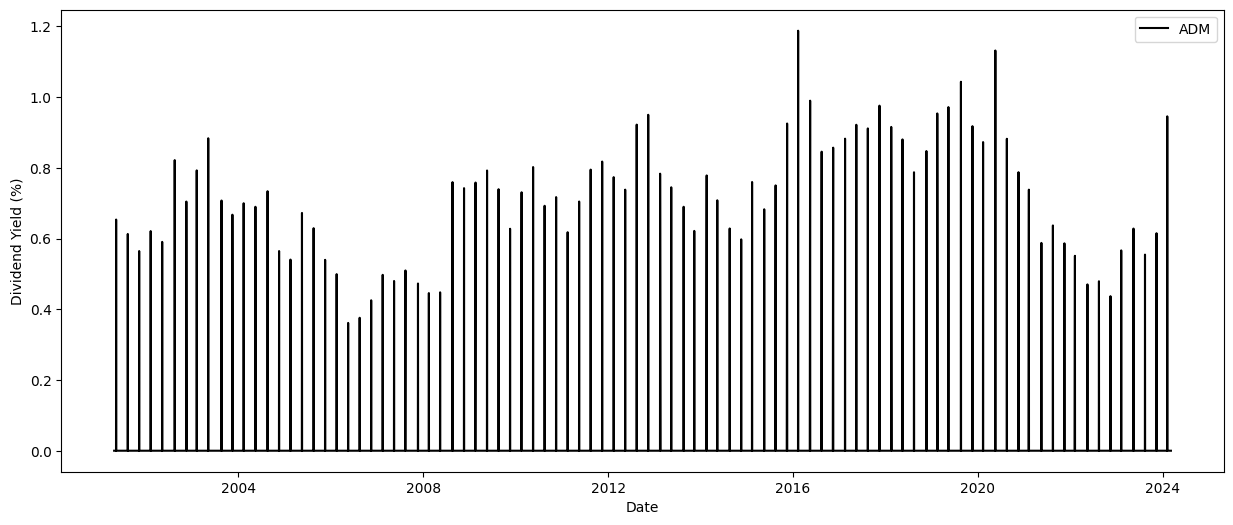

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


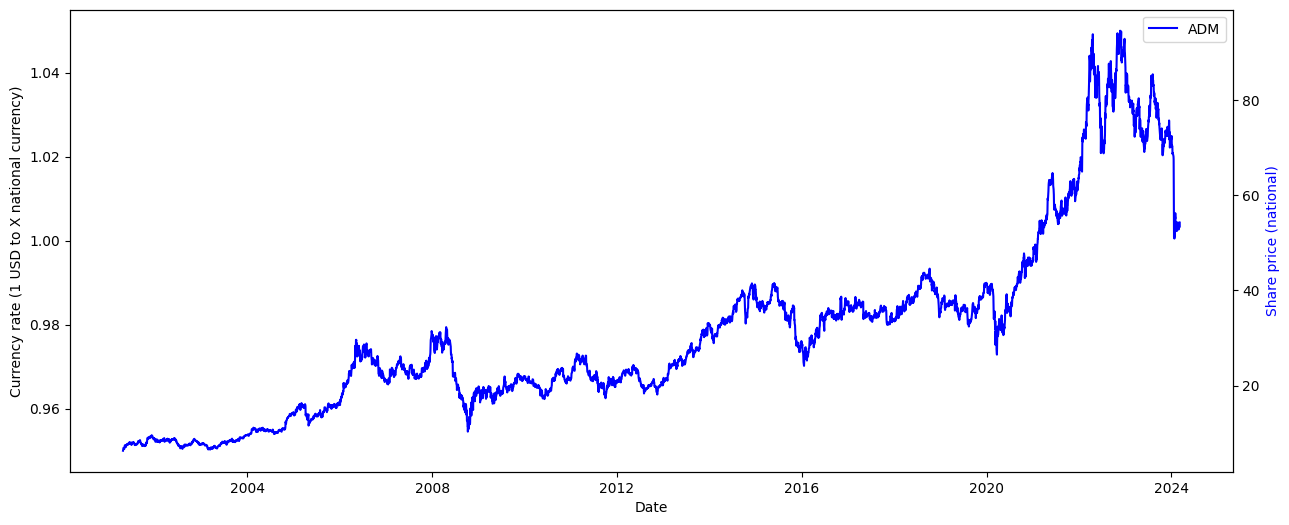

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

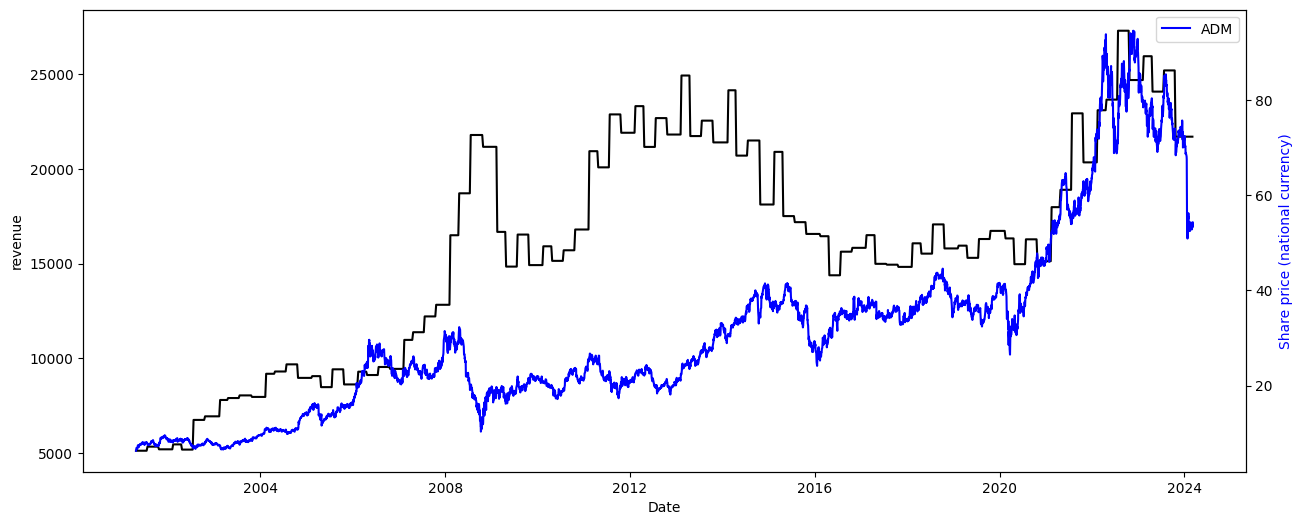

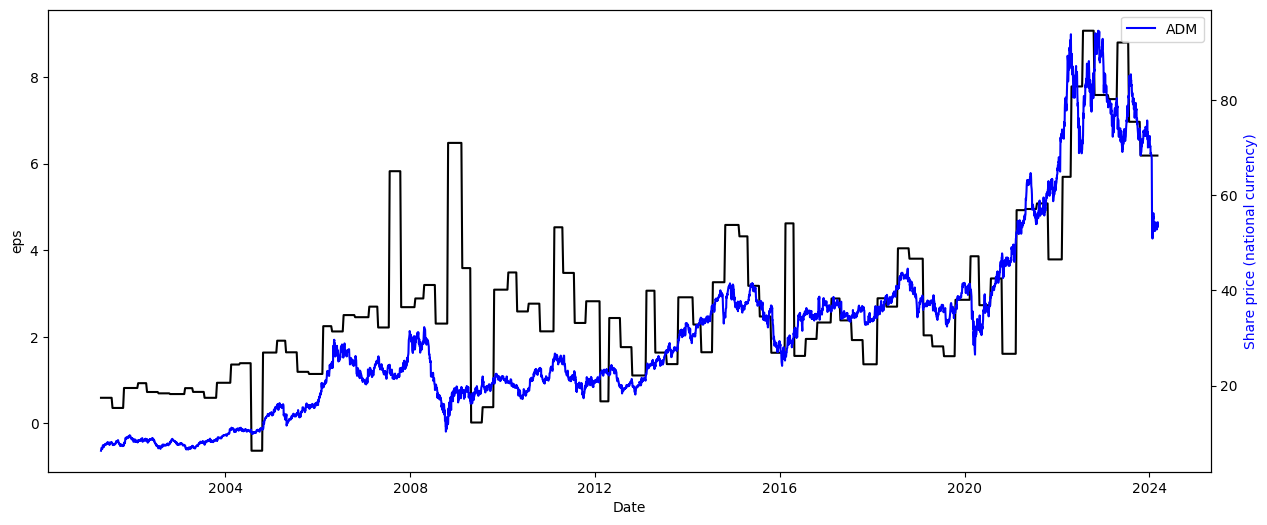

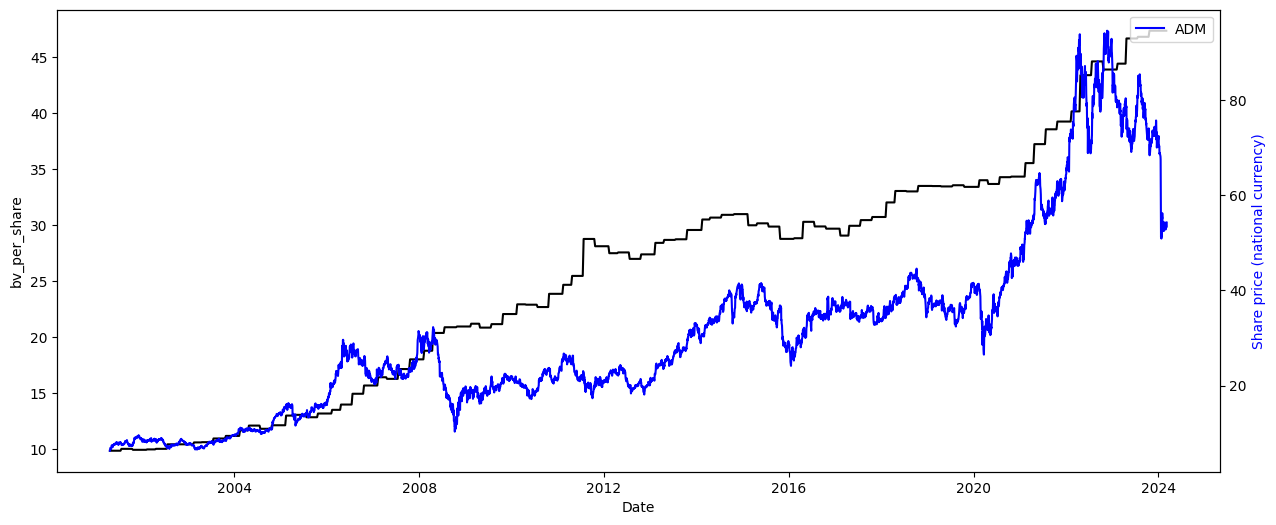

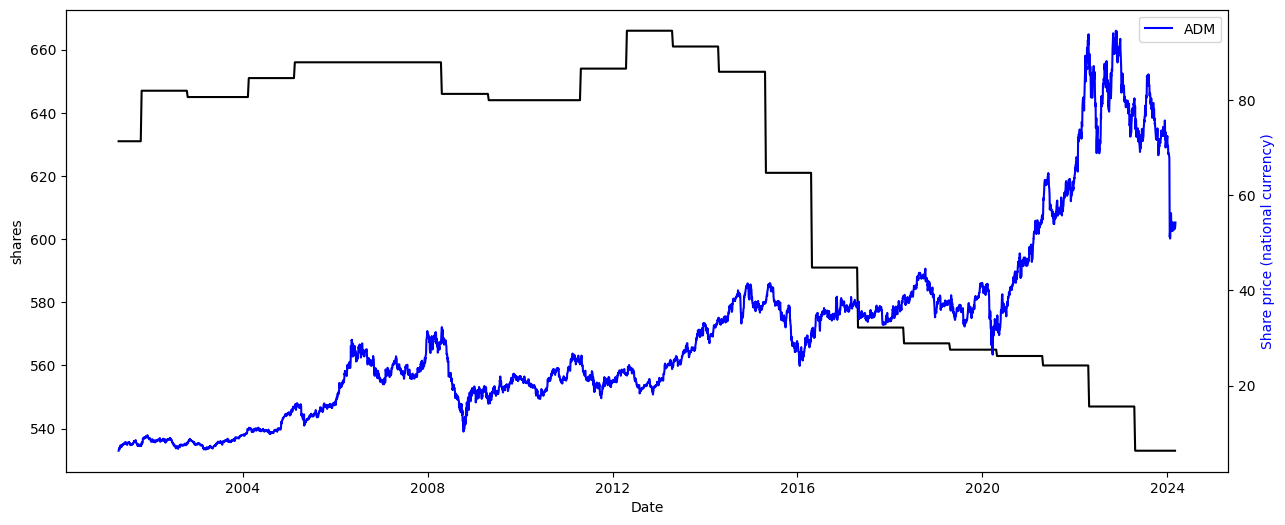

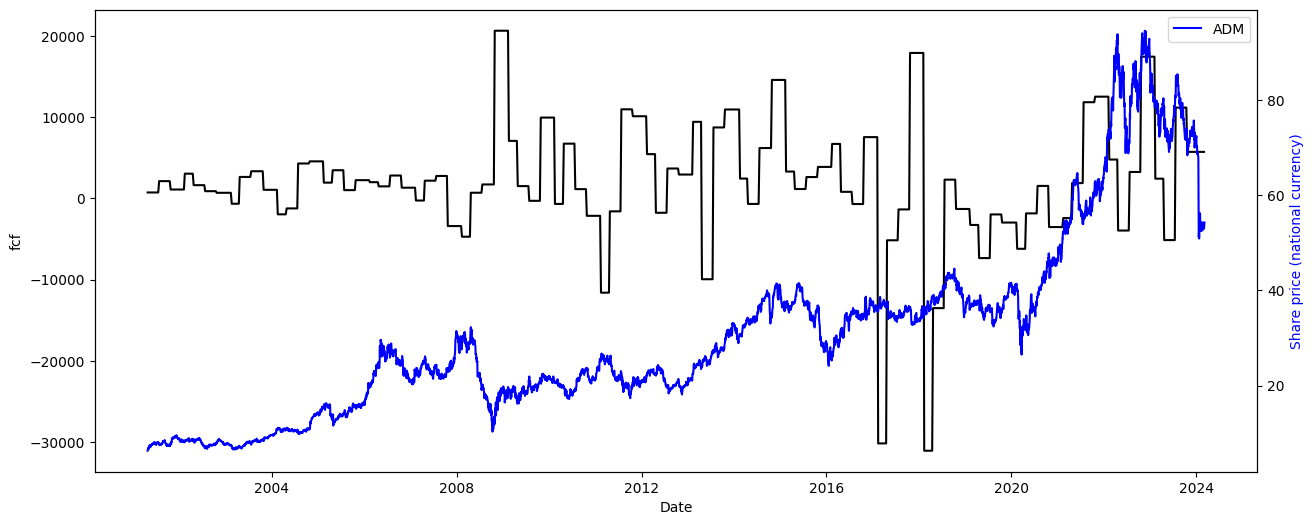

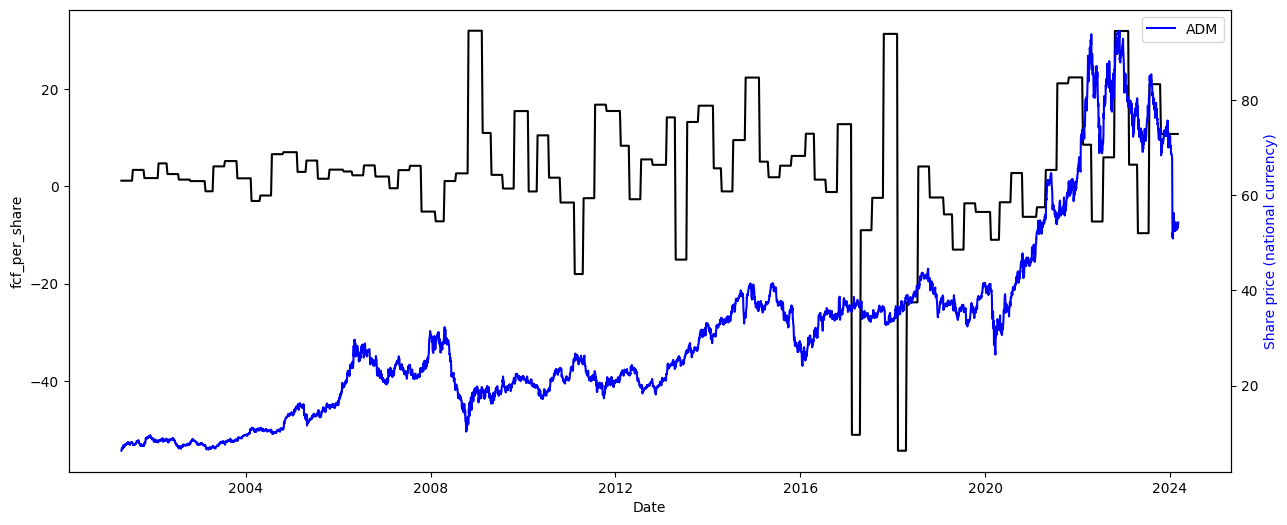

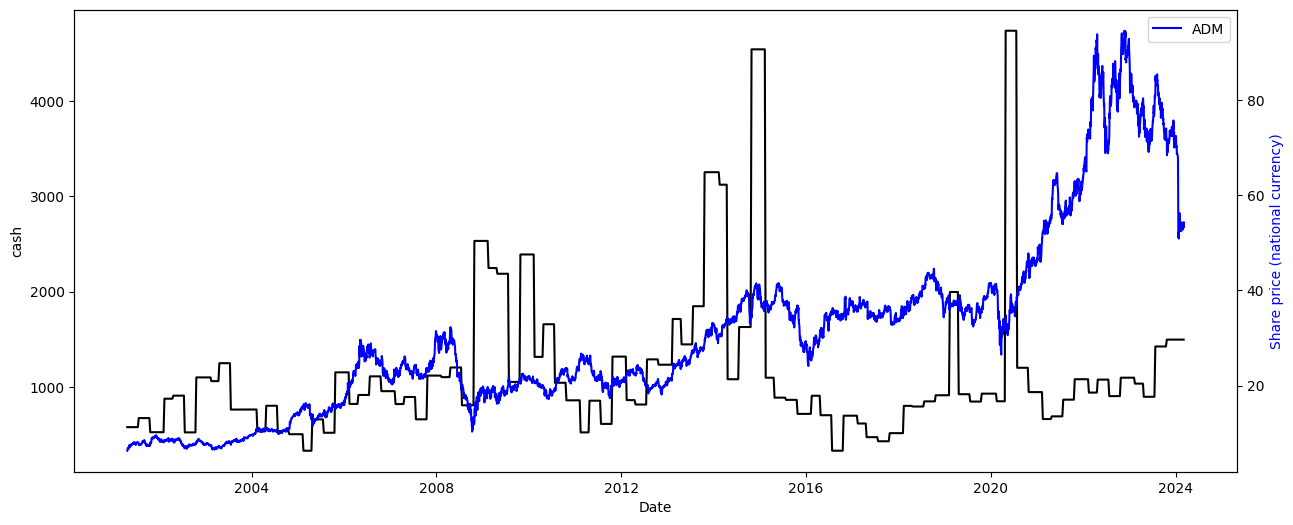

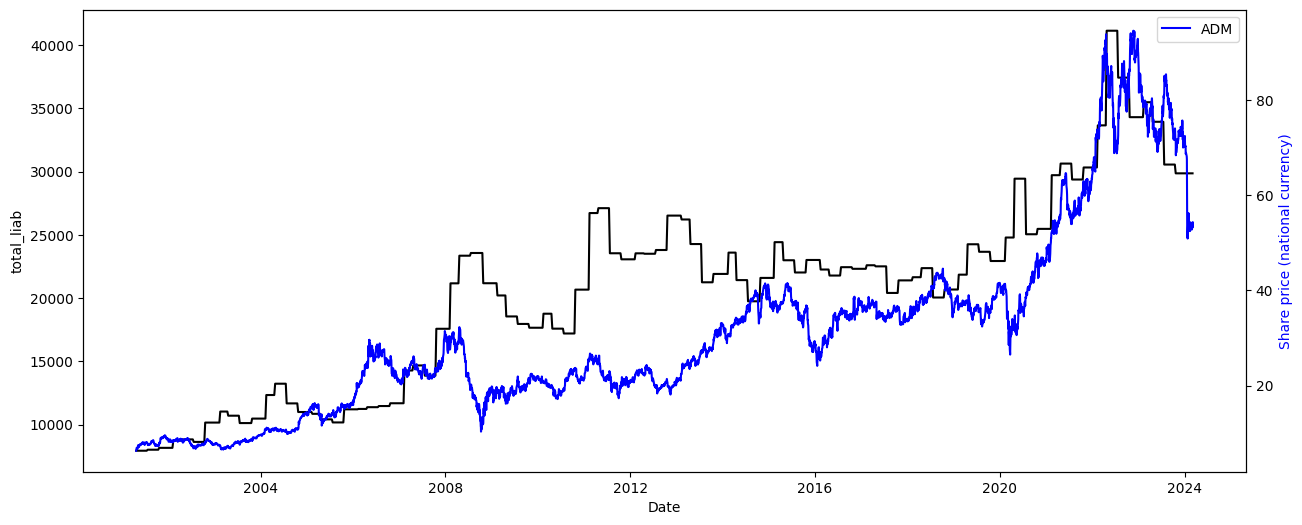

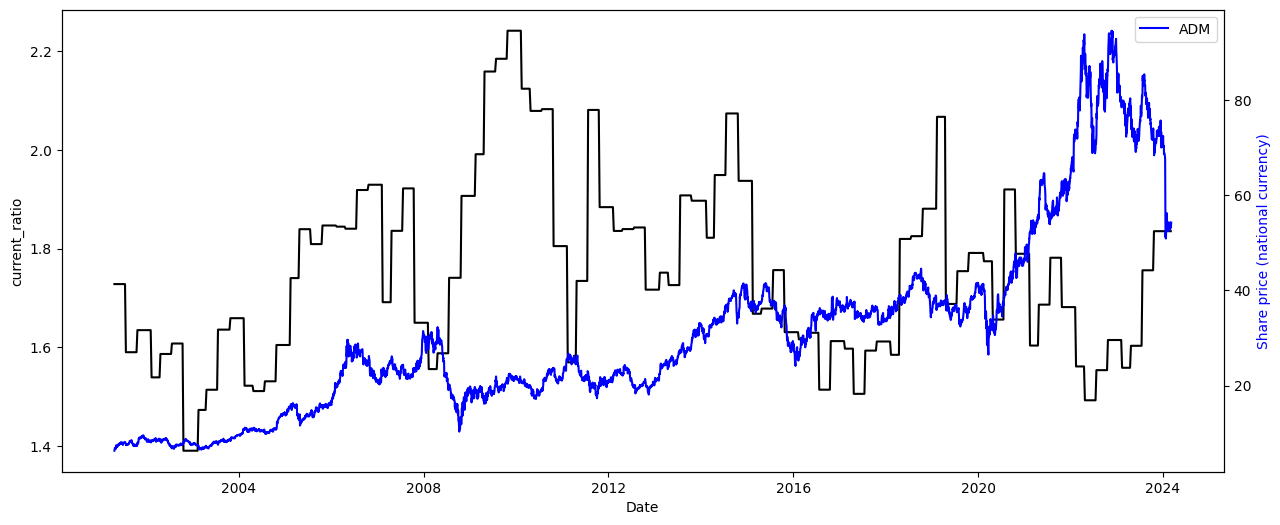

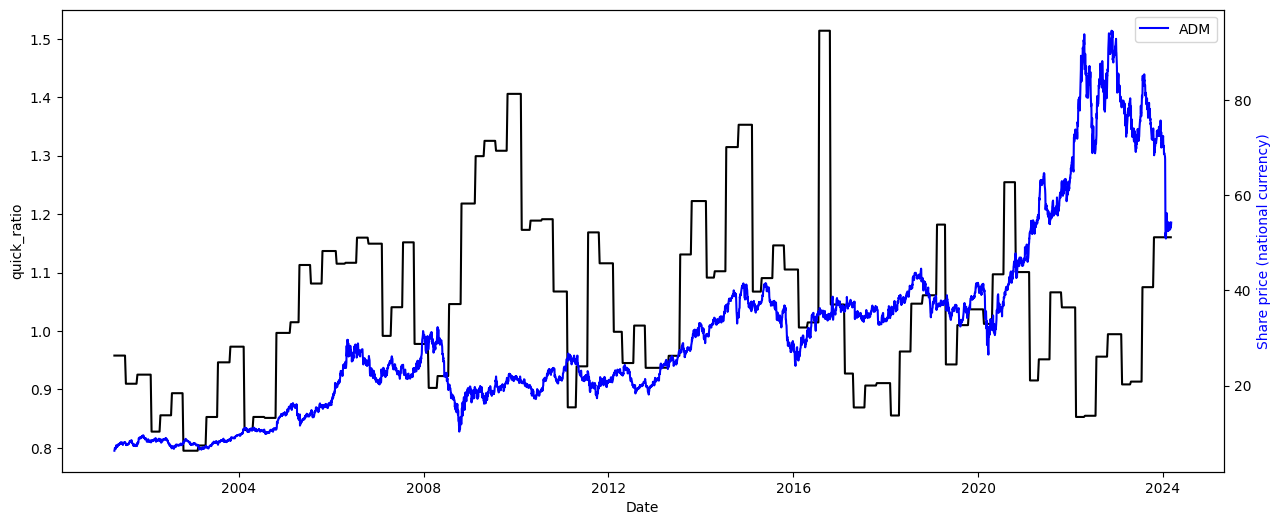

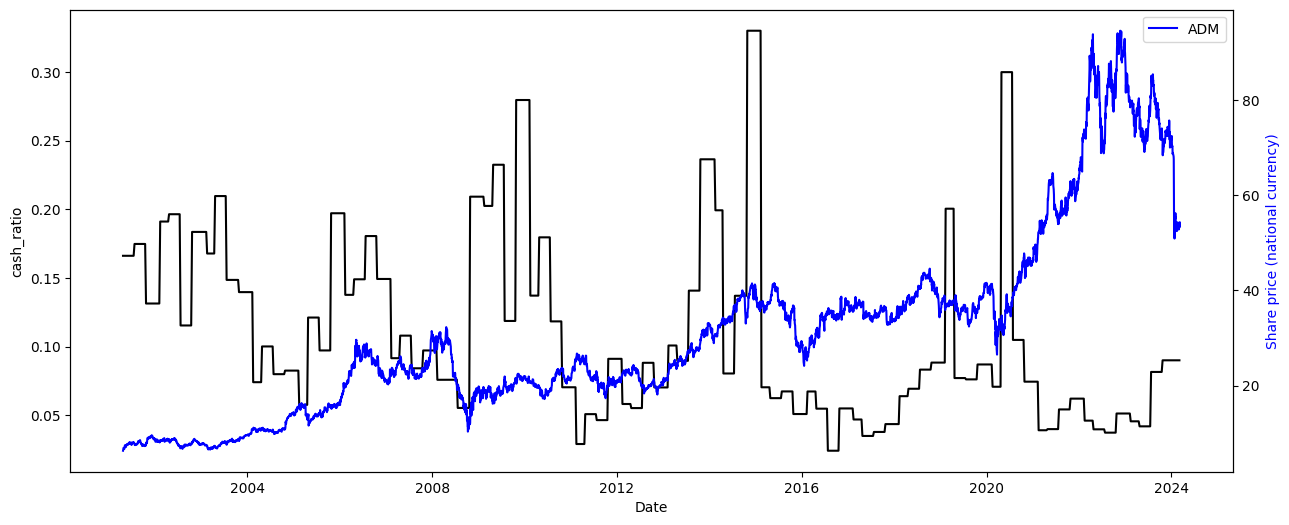

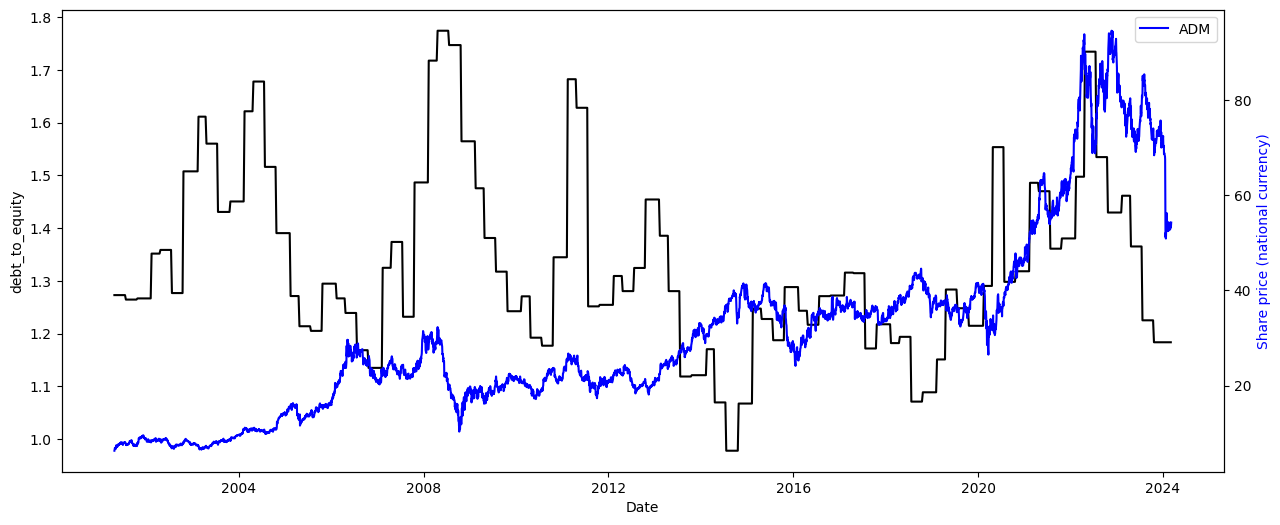

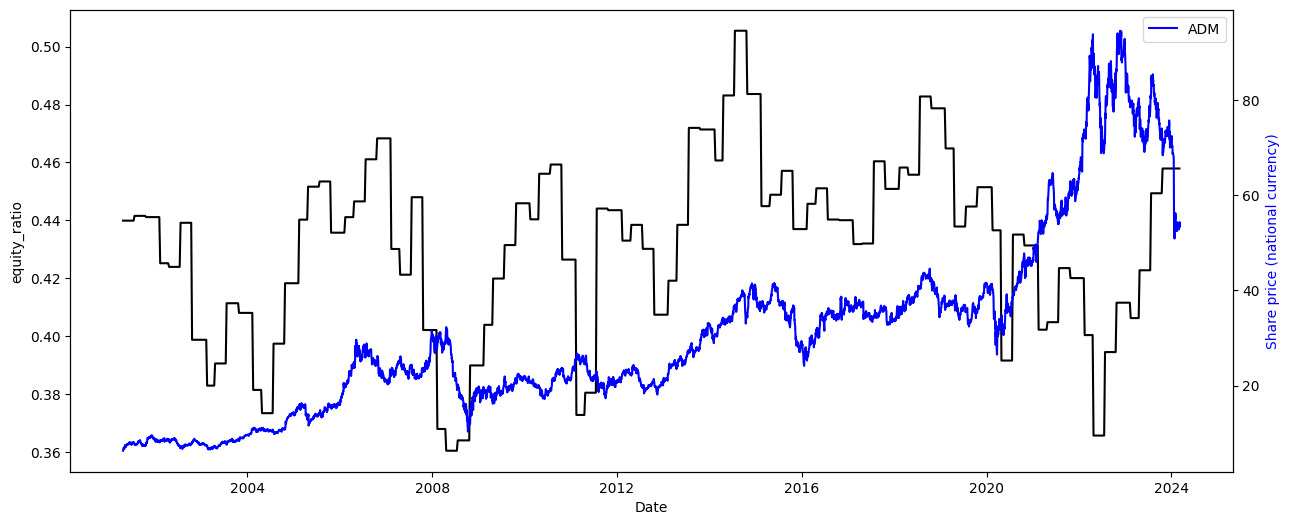

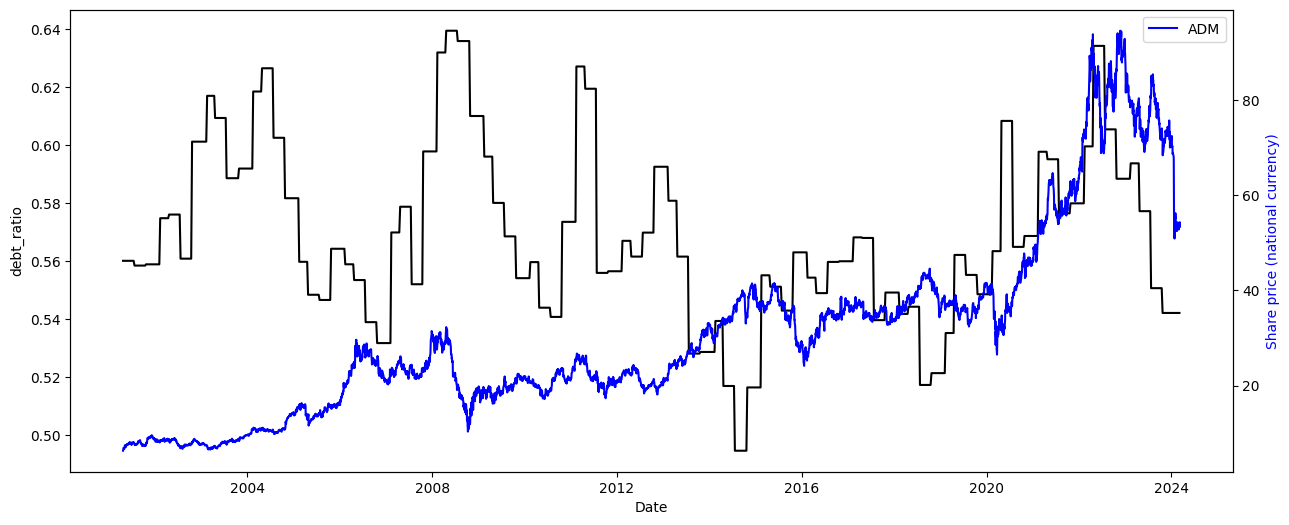

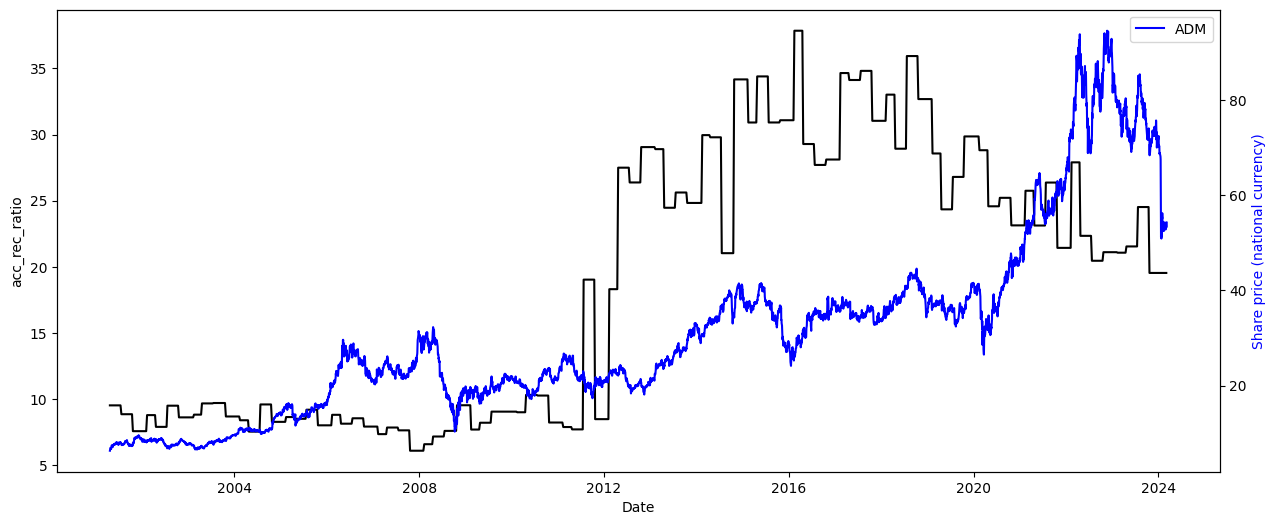

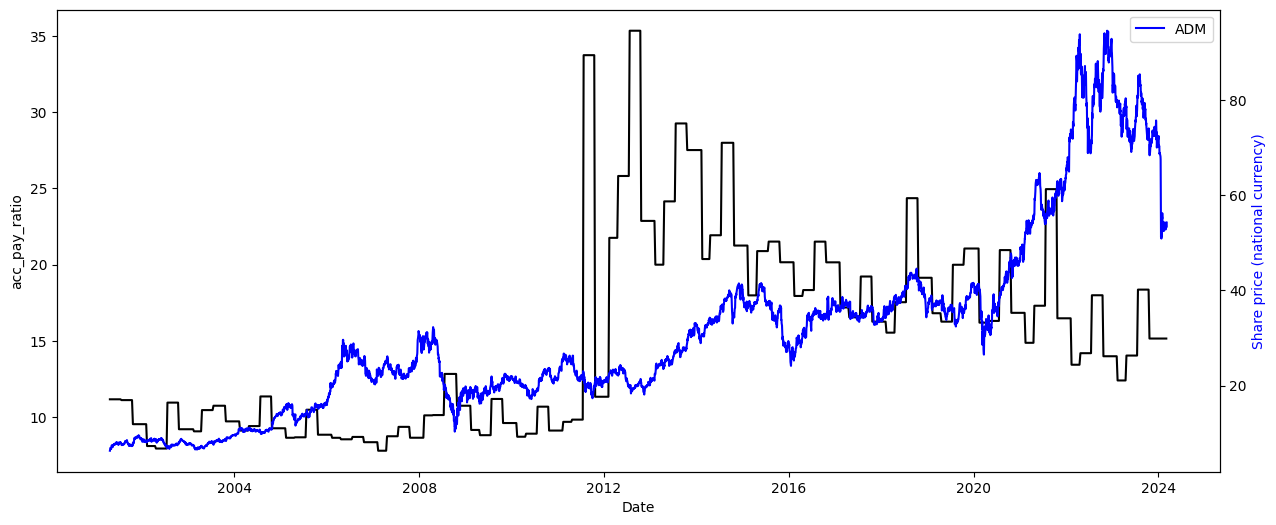

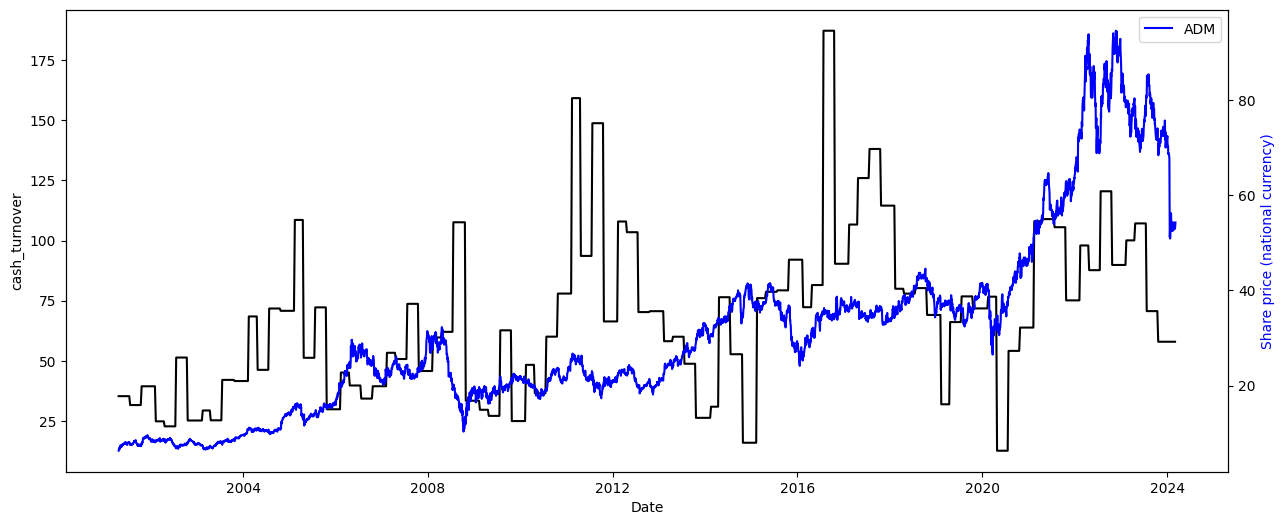

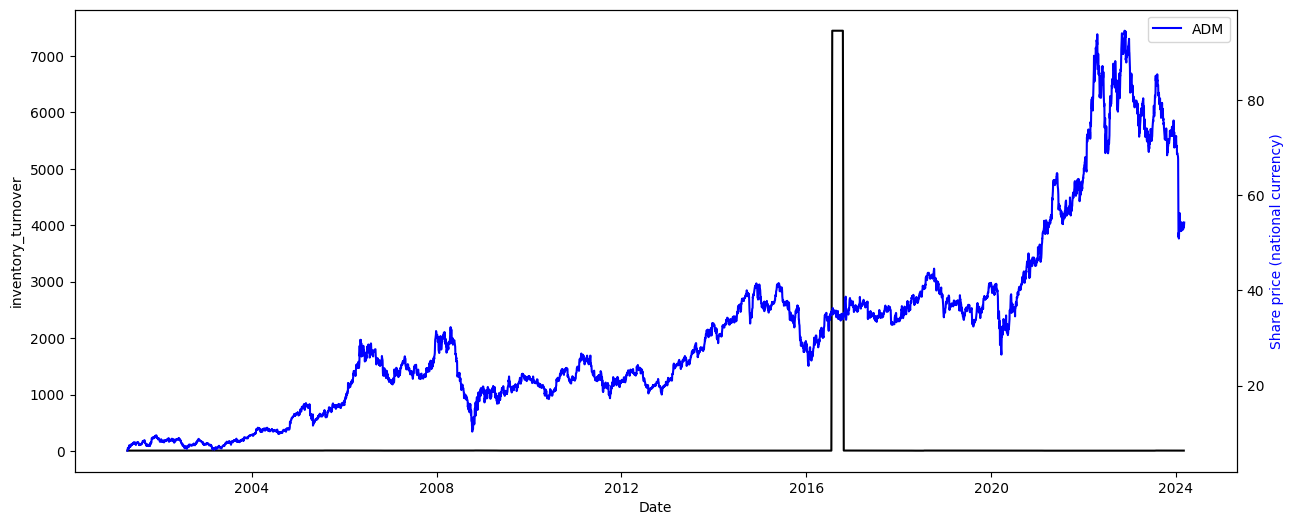

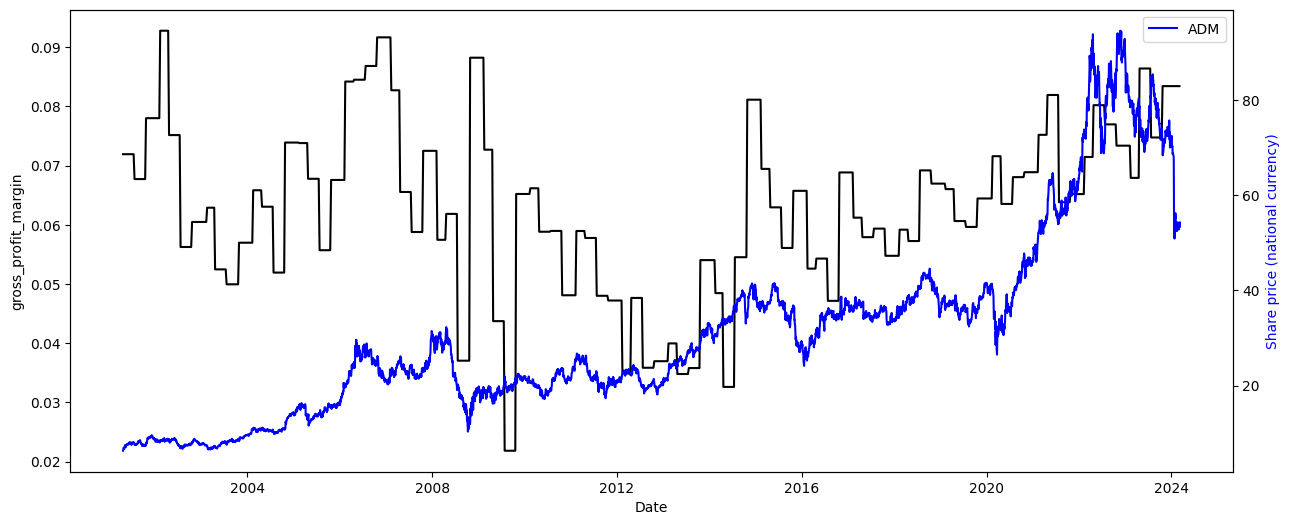

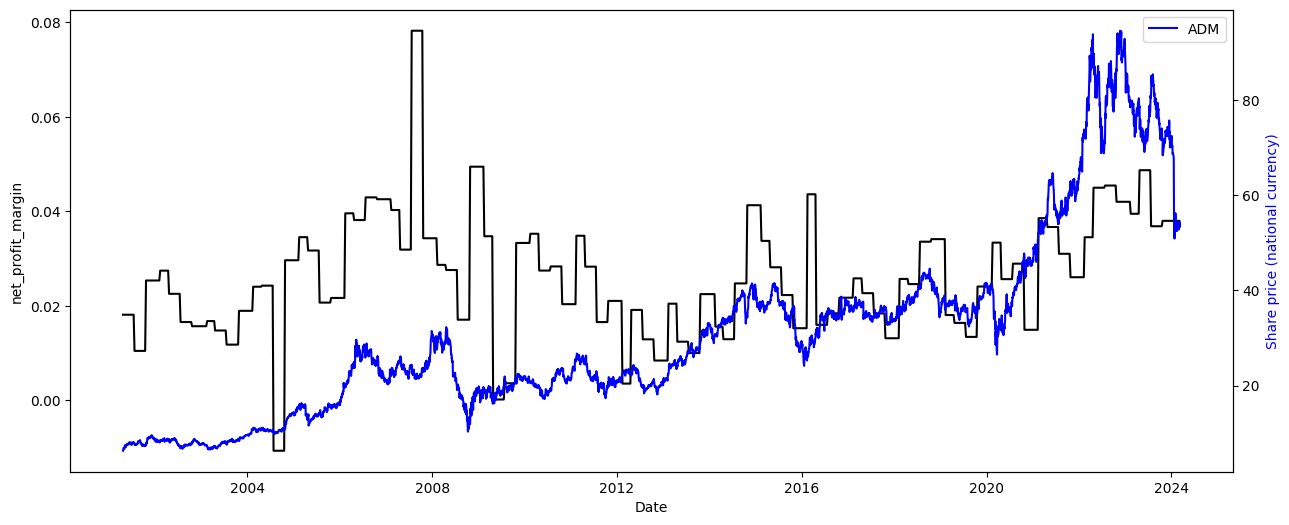

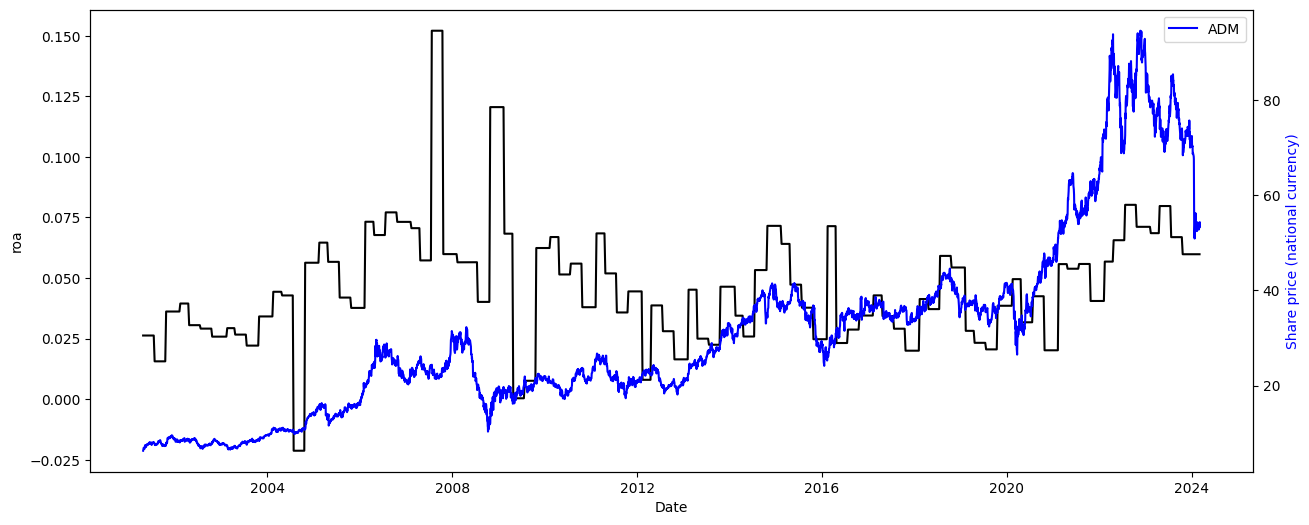

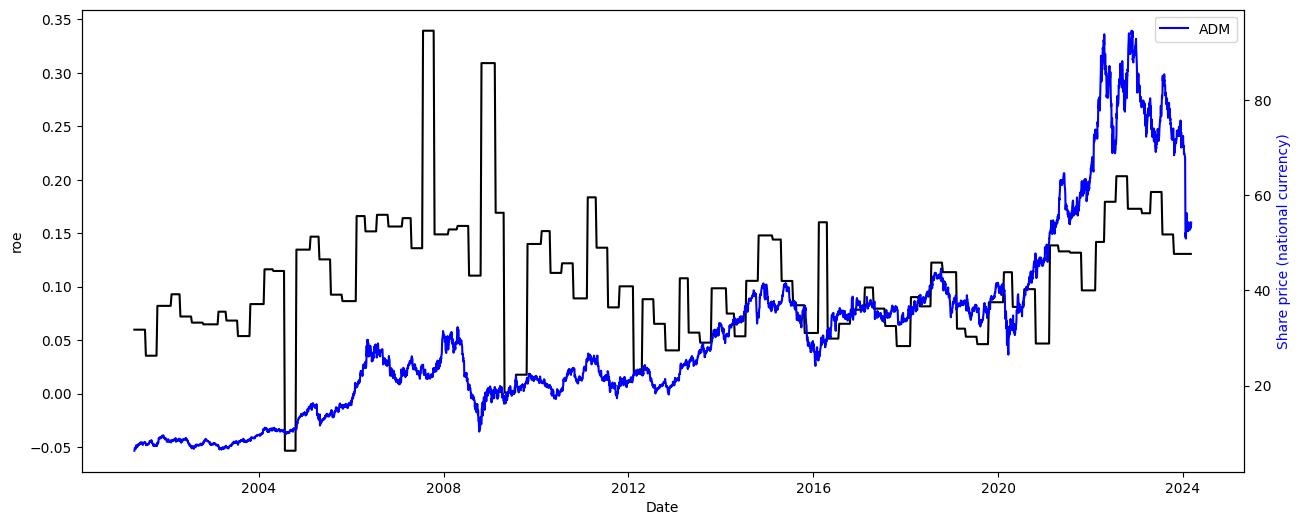

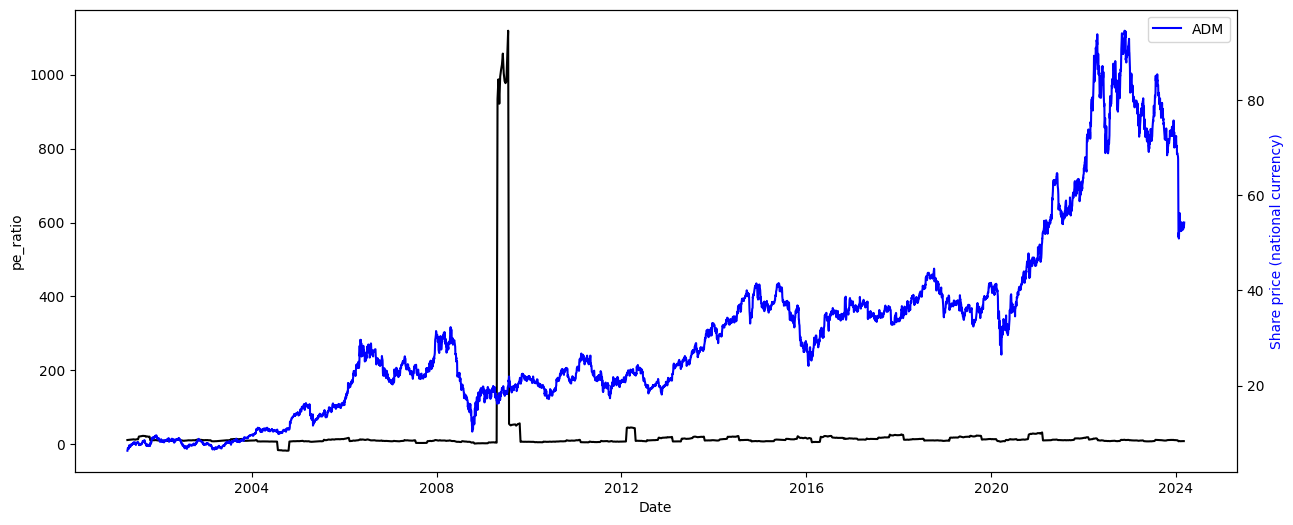

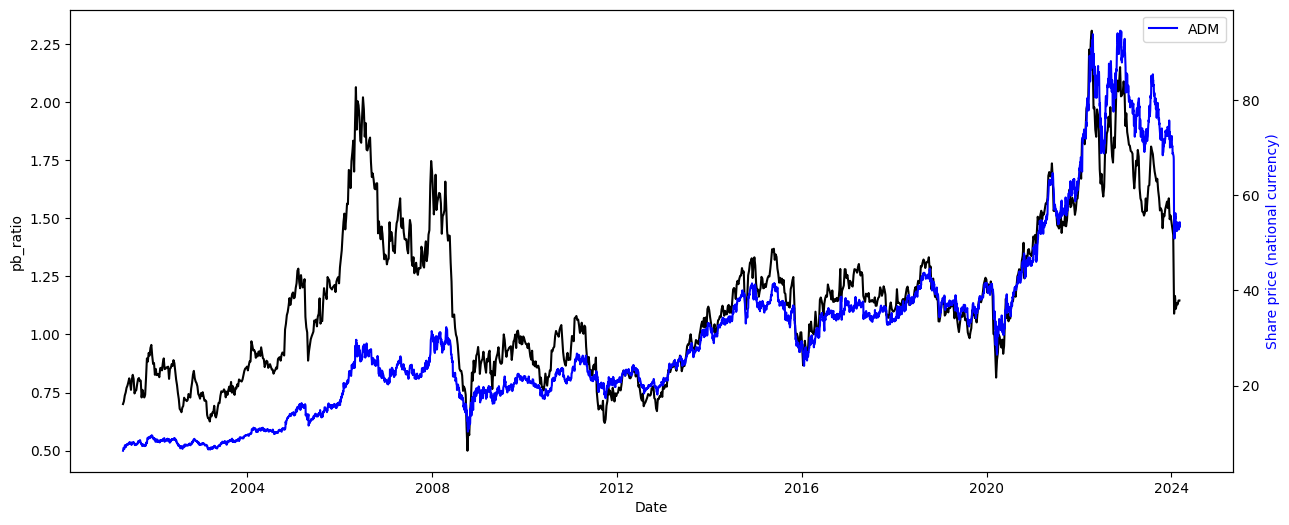

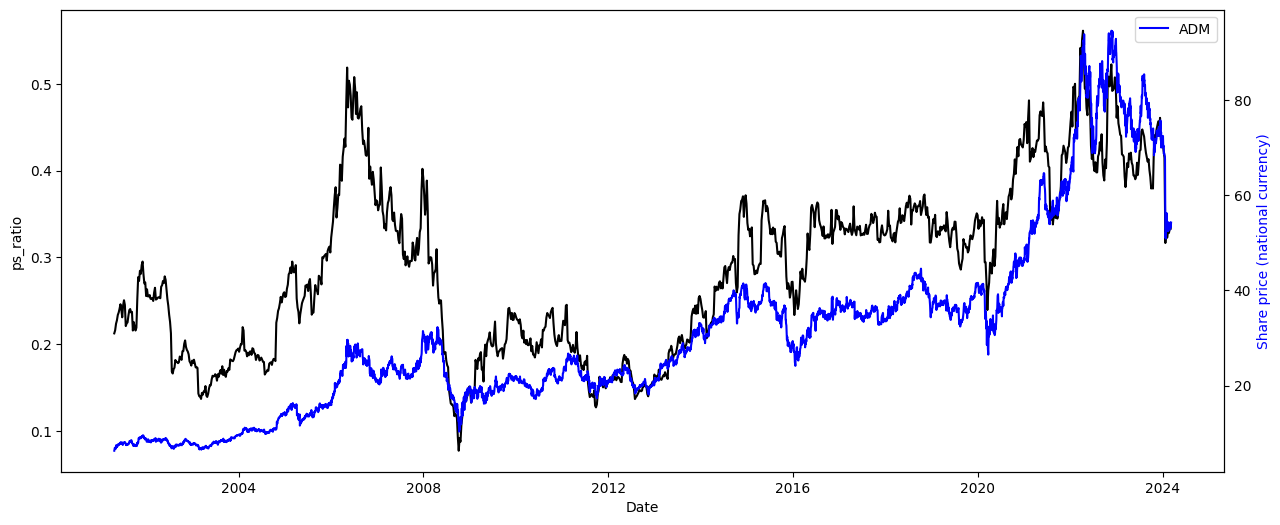

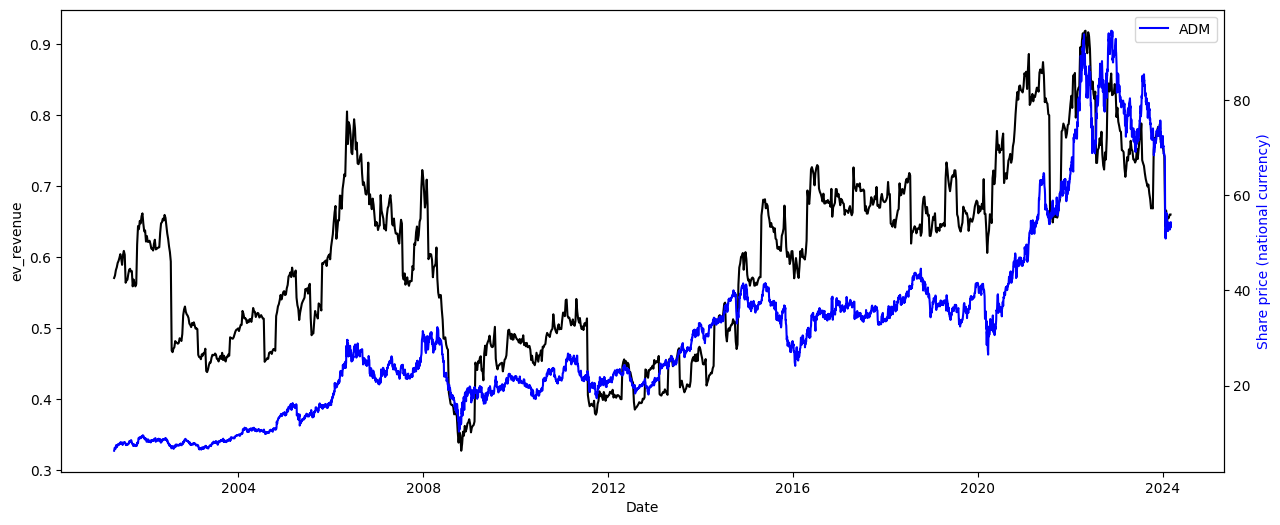

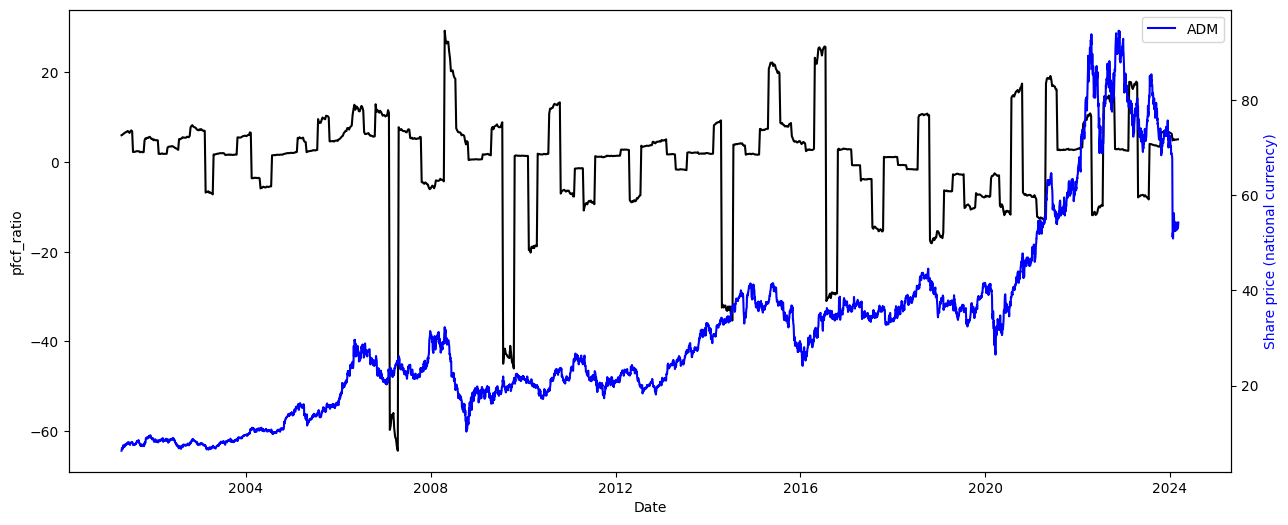

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

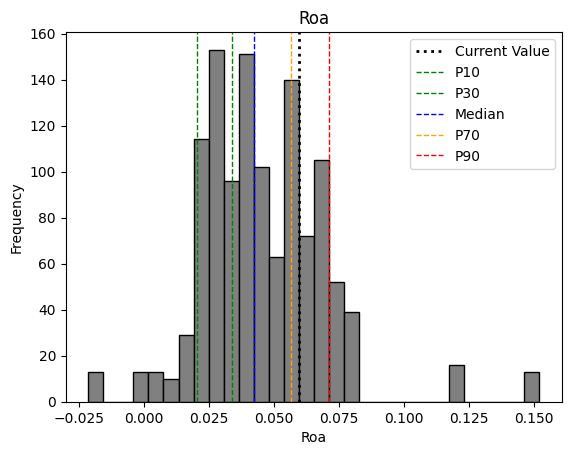

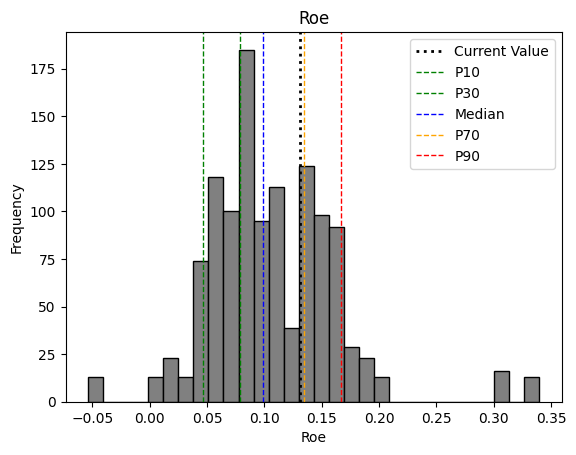

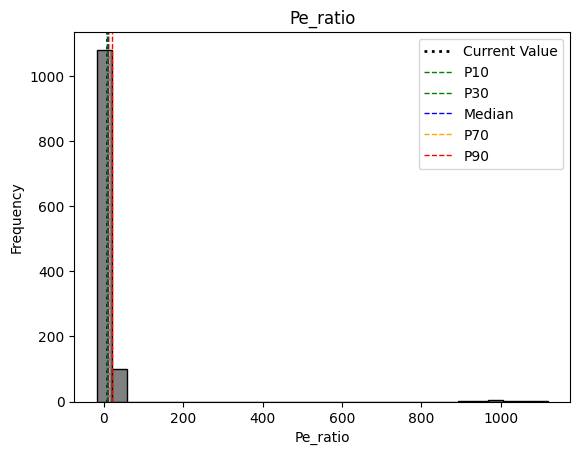

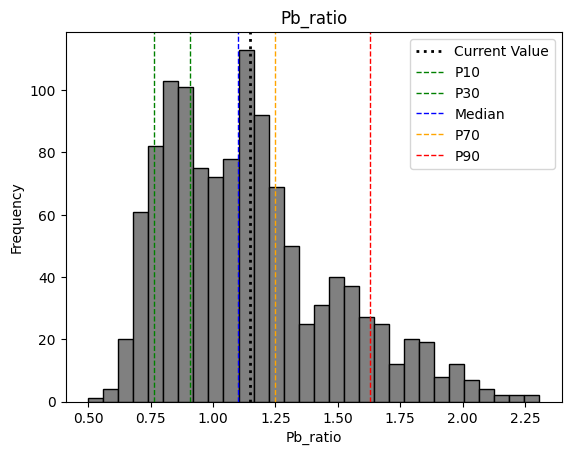

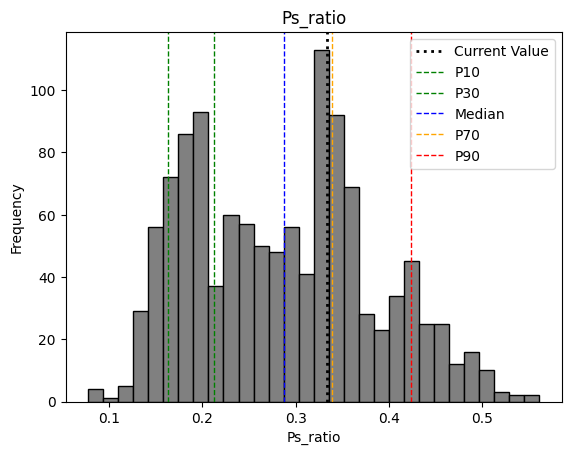

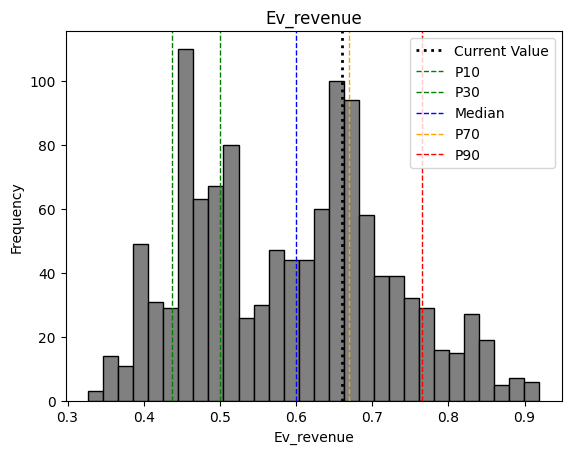

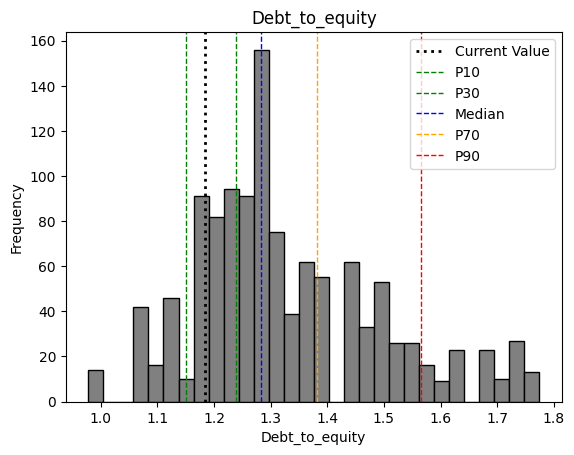

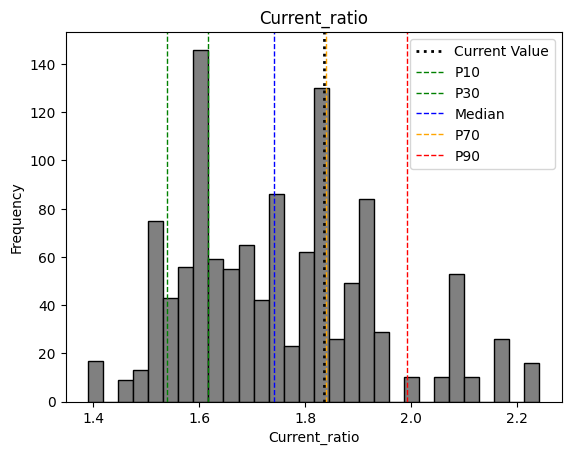

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.986890,-0.228281,0.453433,0.305360,0.169744,0.025640,0.156642
roe,0.986890,1.000000,-0.223782,0.446198,0.270730,0.162098,0.174224,0.078424
pe_ratio,-0.228281,-0.223782,1.000000,-0.074794,-0.079590,-0.082524,0.016102,0.243440
pb_ratio,0.453433,0.446198,-0.074794,1.000000,0.913174,0.796573,-0.014872,-0.113721
ps_ratio,0.305360,0.270730,-0.079590,0.913174,1.000000,0.946099,-0.208626,-0.130605
ev_revenue,0.169744,0.162098,-0.082524,0.796573,0.946099,1.000000,-0.048267,-0.320978
debt_to_equity,0.025640,0.174224,0.016102,-0.014872,-0.208626,-0.048267,1.000000,-0.512594
current_ratio,0.156642,0.078424,0.243440,-0.113721,-0.130605,-0.320978,-0.512594,1.000000


180 timestemos have been found!


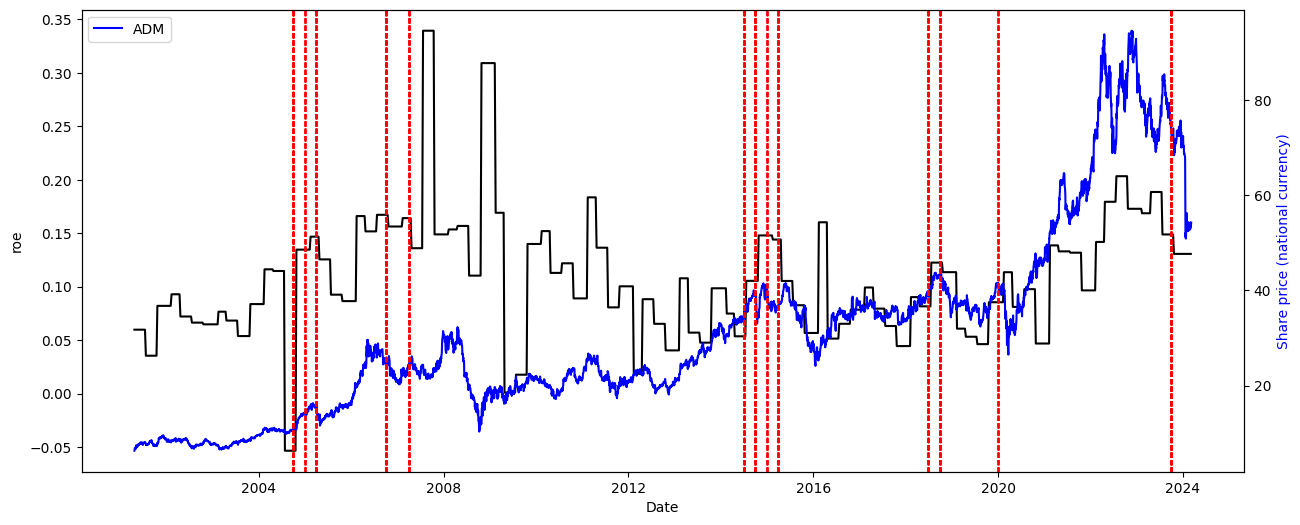

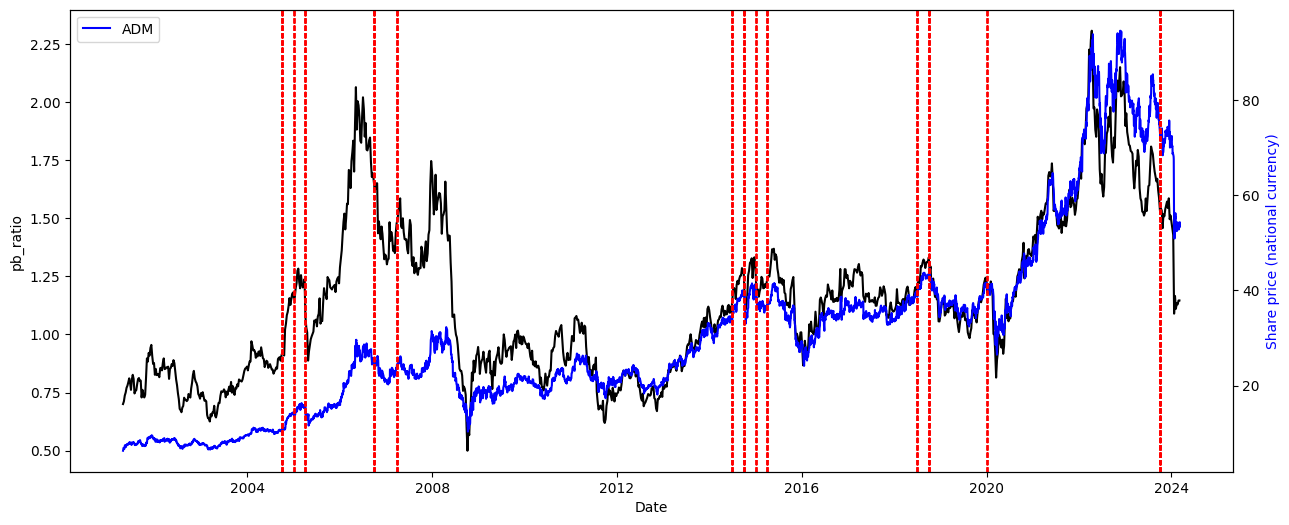

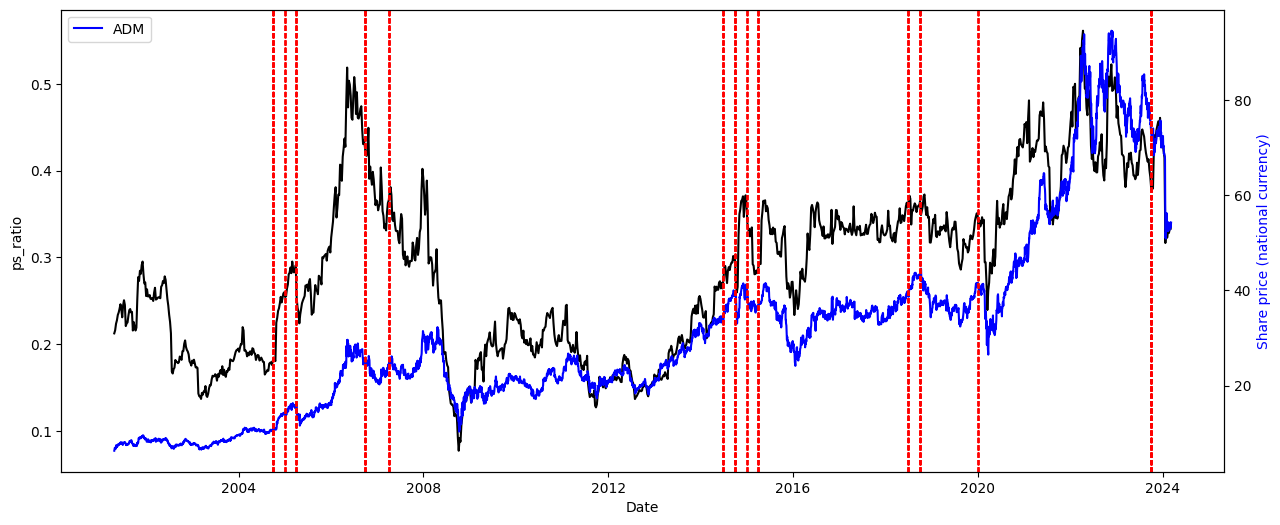

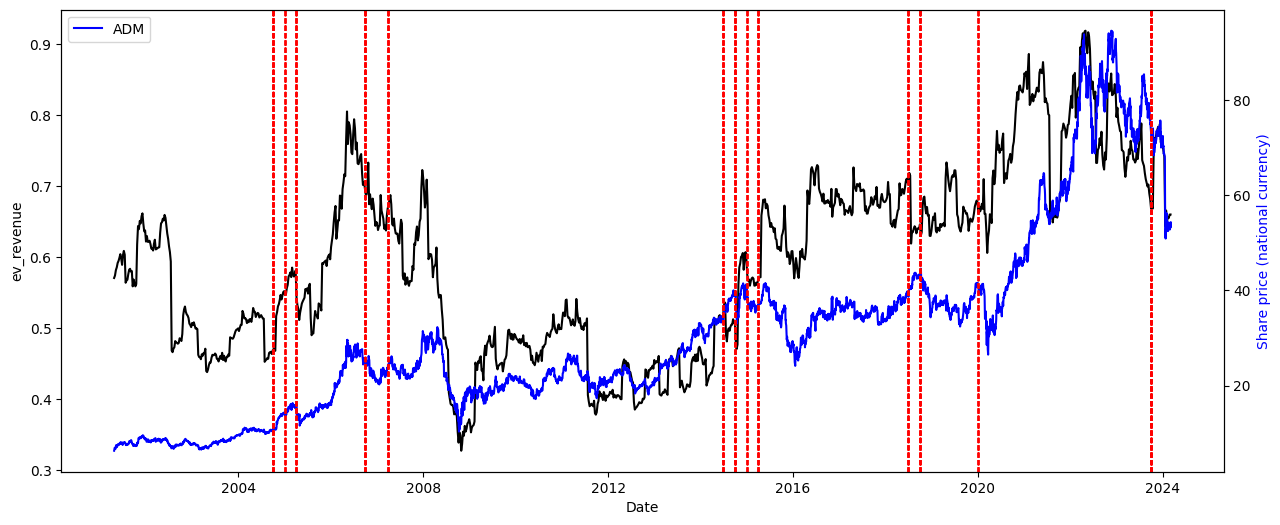

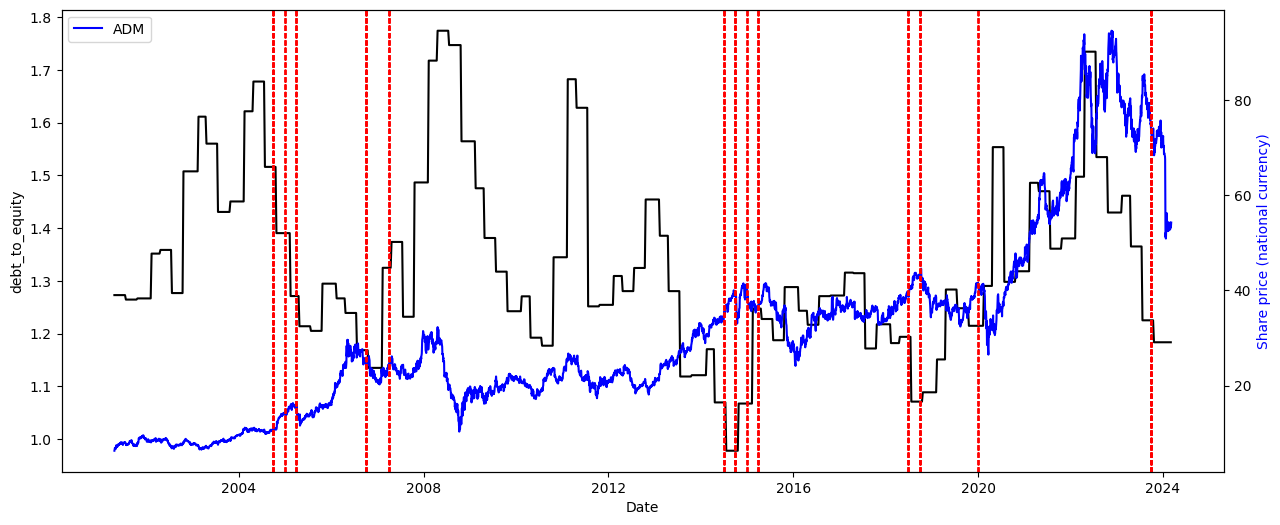

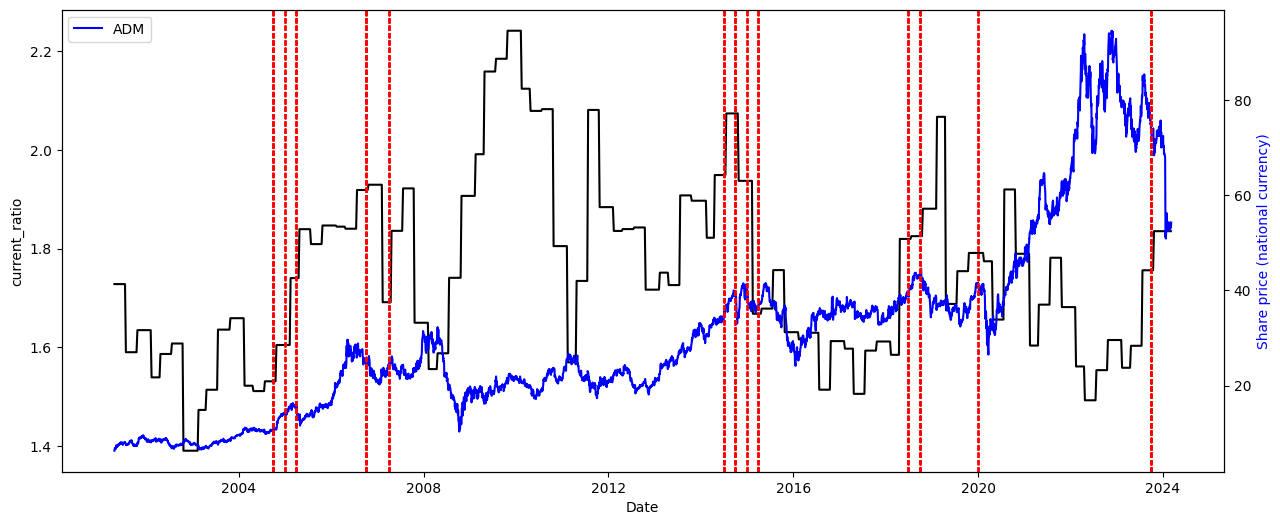

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )